In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
f = open('plotlyapi.txt', "r")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
tools.set_credentials_file(username='mherdt', api_key=f)

# Reading the data

In [147]:
df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Renaming the columns:

In [148]:
df.columns = [col.replace(' ', '_').lower() for col in df.columns]

df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


more information on the data set checking for non and zero values. 

In [149]:
df.info()
df.describe()
df.columns
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
age                 1000 non-null int64
sex                 1000 non-null object
job                 1000 non-null int64
housing             1000 non-null object
saving_accounts     817 non-null object
checking_account    606 non-null object
credit_amount       1000 non-null int64
duration            1000 non-null int64
purpose             1000 non-null object
risk                1000 non-null object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


checking_account    394
saving_accounts     183
risk                  0
purpose               0
duration              0
credit_amount         0
housing               0
job                   0
sex                   0
age                   0
dtype: int64

We creating new columns for further EDA.

In [150]:
##### Gender Analysis

df['sex'].value_counts()

by_age = df['age'].values.tolist()
male_age = df['age'].loc[df['sex'] == 'male'].values.tolist()
female_age = df['age'].loc[df['sex'] == 'female'].values.tolist()



In [151]:



trace0 = go.Histogram(
   x=male_age,
   histnorm='probability',
   name="German Male",
   marker = dict(
       color = 'rgba(100, 149, 237, 0.6)',
   )
)
trace1 = go.Histogram(
   x=female_age,
   histnorm='probability',
   name="German Female",
   marker = dict(
       color = 'rgba(255, 182, 193, 0.6)',
   )
)
trace2 = go.Histogram(
   x=by_age,
   histnorm='probability',
   name="Overall Gender",
    marker = dict(
       color = 'rgba(169, 169, 169, 0.6)',
   )
)
fig = tools.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                         subplot_titles=('Males','Female', 'All Genders'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Distribution of Gender', bargap=0.05)
py.iplot(fig, filename='stacked histogram')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



In [152]:
import plotly.figure_factory as ff
# Group data together
hist_data = [by_age, female_age, male_age]

group_labels = ['Overall Gender', 'German Female', 'German Male']

colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=3, show_rug=False)

# Add title
fig['layout'].update(title='Hist and Curve Plot')

# Plot!
py.iplot(fig, filename='Hist and Curve')

In [153]:
x = male_age
y = female_age


data = [
    go.Histogram2dContour(
        x = x,
        y = y,
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ),
    go.Scatter(
        x = x,
        y = y,
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,0.3)',
            size = 3
        )
    ),
    go.Histogram(
        y = y,
        xaxis = 'x2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ),
    go.Histogram(
        x = x,
        yaxis = 'y2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    )
]

layout = go.Layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False
)



fig = go.Figure(data=data,layout=layout)
fig['layout'].update(title='Histogram 2d Contour Male / Female')
py.iplot(fig, filename='Histogram2dContour Subplot')

In [154]:
######## Purpose analysis

df['purpose'].unique()
sex_purpose = pd.crosstab(df['purpose'], df['sex']).apply(lambda x: x/x.sum() * 100)
print(sex_purpose)

purpose = df['purpose'].unique().tolist()
#purpose = ['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       #'domestic appliances', 'repairs', 'vacation/others']
#np.asarray(purpose)
m_purpose = sex_purpose['male']
f_purpose = sex_purpose['female']

print(m_purpose)



sex                     female       male
purpose                                  
business              6.129032  11.304348
car                  30.322581  35.217391
domestic appliances   1.935484   0.869565
education             7.741935   5.072464
furniture/equipment  23.870968  15.507246
radio/TV             27.419355  28.260870
repairs               1.612903   2.463768
vacation/others       0.967742   1.304348
purpose
business               11.304348
car                    35.217391
domestic appliances     0.869565
education               5.072464
furniture/equipment    15.507246
radio/TV               28.260870
repairs                 2.463768
vacation/others         1.304348
Name: male, dtype: float64


In [155]:

x = purpose
y = m_purpose
y2 = f_purpose

trace1 = go.Bar(
    x=x,
    y=y,
    text=y,
    textposition = 'auto',
    name='Gender Male Purpose',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

trace2 = go.Bar(
    x=x,
    y=y2,
    text=y2,
    textposition = 'auto',
    name='Gender Female Purpose',
    marker=dict(
        color='rgb(58,200,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data = [trace1,trace2]

fig['layout'].update(title='Purpose Male / Female')
py.iplot(data, filename='grouped-bar-direct-labels')

In [156]:
################ Number of Jobs

number_of_jobs = pd.crosstab(df["job"], df["sex"]).apply(lambda x: x/x.sum() * 100)
number_of_jobs

job_number_m = number_of_jobs["male"].values.tolist()
job_number_f = number_of_jobs["female"].values.tolist()


In [157]:
fig = {
    'data': [
        {
            'labels': ['Unemployed','One Jobs','Two Jobs','Three Jobs'],
            'values': job_number_m,
            'type': 'pie',
            'name': 'Male',
            'marker': {'colors': ['rgb(56, 75, 126)',
                                  'rgb(18, 36, 37)',
                                  'rgb(34, 53, 101)',
                                  'rgb(36, 55, 57)'
                                  ]},

            'hoverinfo':'label+percent+name',
            "domain": {"column": 0},
            'textinfo':'percent'
        },
        {
            'labels': ['Unemployed','One Jobs','Two Jobs','Three Jobs'],
            'values': job_number_f,
            'marker': {'colors': ['rgb(177, 127, 38)',
                                  'rgb(205, 152, 36)',
                                  'rgb(99, 79, 37)',
                                  'rgb(129, 180, 179)']},
            'type': 'pie',
            'name': 'Female',

            'hoverinfo':'label+percent+name',
            "domain": {"column": 1},
            'textinfo':'percent'

        }    ],

    'layout': {'title': 'Number of Jobs: Male (left) and Female (right)',
               "grid": {"rows": 1, "columns": 2},
               'showlegend': True}
}

py.iplot(fig, filename='pie_chart_subplots')

In [158]:
df['Age_Group'] = np.nan
df.loc[(df['age'] > 18) & (df['age'] <= 29), 'Age_Group'] = 'Young'
df.loc[(df['age'] > 29) & (df['age'] <= 40), 'Age_Group'] = 'Young Adults'
df.loc[(df['age'] > 40) & (df['age'] <= 55), 'Age_Group'] = 'Senior'
df.loc[df['age'] > 55, 'Age_Group'] = 'Elder'


# Credit Amount in die Liste 
young = df['credit_amount'].loc[df['Age_Group'] == 'Young'].values.tolist()
young_adults = df['credit_amount'].loc[df['Age_Group'] == 'Young Adults'].values.tolist()
senior = df['credit_amount'].loc[df['Age_Group'] == 'Senior'].values.tolist()
elder_credit = df['credit_amount'].loc[df['Age_Group'] == 'Elder'].values.tolist()

In [159]:
############ Good vs. Bad Credit 
good_credit_df = df.loc[df['risk'] == "good"]
bad_credit_df = df.loc[df['risk'] == "bad"]
#good_credit_df.groupby(['Age_Group']).get_group('Young')
young2 = df[['credit_amount','risk']].loc[df['Age_Group'] == 'Young']
young_adults2= df[['credit_amount','risk']].loc[df['Age_Group'] == 'Young Adults']
senior2 = df[['credit_amount','risk']].loc[df['Age_Group'] == 'Senior']
elder_credit2 = df[['credit_amount','risk']].loc[df['Age_Group'] == 'Elder']

In [183]:
trace0 = go.Box(
    y=good_credit_df["credit_amount"],
    x=good_credit_df["Age_Group"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=bad_credit_df['credit_amount'],
    x=bad_credit_df ['Age_Group'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

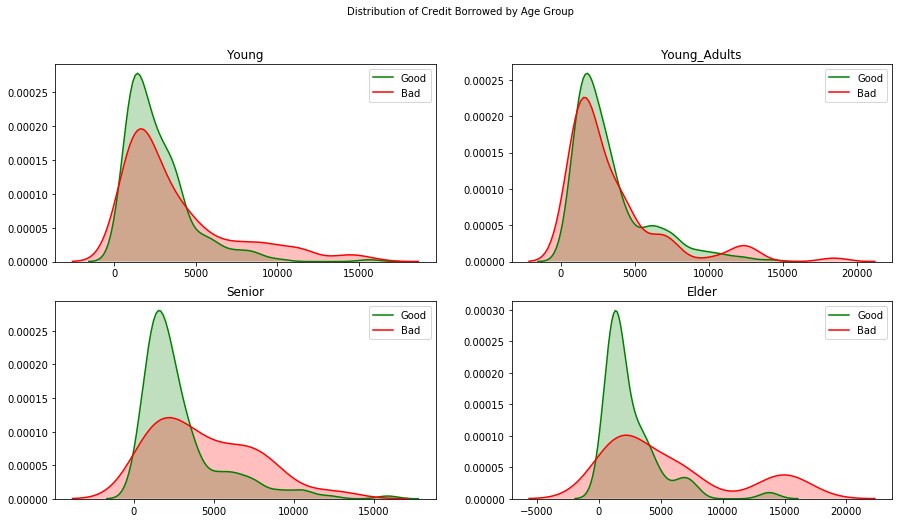

In [160]:
fig6, ax6 =plt.subplots(2,2, figsize=(15,8))
fig6.suptitle('Distribution of Credit Borrowed by Age Group', fontsize=10)


sns.kdeplot(young2['credit_amount'].loc[young2['risk'] == 'good'], shade=True, color="g", ax =ax6[0][0])
sns.kdeplot(young2['credit_amount'].loc[young2['risk'] == 'bad'], shade=True, color="r",ax =ax6[0][0])
ax6[0][0].title.set_text('Young')
ax6[0][0].legend(['Good','Bad'])

sns.kdeplot(young_adults2['credit_amount'].loc[young_adults2['risk'] == 'good'], shade=True, color="g",ax =ax6[0][1])    
sns.kdeplot(young_adults2['credit_amount'].loc[young_adults2['risk'] == 'bad'], shade=True, color="r",ax =ax6[0][1])   
ax6[0][1].title.set_text('Young_Adults')
ax6[0][1].legend(['Good','Bad'])

sns.kdeplot(senior2['credit_amount'].loc[senior2['risk'] == 'good'], shade=True, color="g",ax =ax6[1][0])
sns.kdeplot(senior2['credit_amount'].loc[senior2['risk'] == 'bad'], shade=True, color="r",ax =ax6[1][0]) 
ax6[1][0].title.set_text('Senior')
ax6[1][0].legend(['Good','Bad'])

sns.kdeplot(elder_credit2['credit_amount'].loc[elder_credit2['risk'] == 'good'], shade=True, color="g",ax =ax6[1][1])   
sns.kdeplot(elder_credit2['credit_amount'].loc[elder_credit2['risk'] == 'bad'], shade=True, color="r",ax =ax6[1][1])  
ax6[1][1].title.set_text('Elder')
ax6[1][1].legend(['Good','Bad'])

In [161]:
class FillNAMostCommon(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        most_common_cc = X['checking_account'].value_counts().index[0]
        X = X.fillna(value=most_common_cc)
        most_common_cp = X['saving_accounts'].value_counts().index[0]
        X = X.fillna(value=most_common_cp)
        
        return X

filler_common = FillNAMostCommon()
df_filled = filler_common.transform(df)

We're going to try a naive approch to fill the null values, probably the predictions won't be good. 
We have taken the function from:https://www.kaggle.com/thiagopanini/credit-risk-analysis-eda-full-pipeline


In [162]:
print(df_filled.isnull().sum())

age                 0
sex                 0
job                 0
housing             0
saving_accounts     0
checking_account    0
credit_amount       0
duration            0
purpose             0
risk                0
Age_Group           0
dtype: int64


In [168]:
# Indexing data
X = df_filled.drop('risk',1)
y = df_filled.iloc[:, -2]

# Changing label
y = (y == 'bad')*1

print(X.head())


#bad risk = 0
#good risk = 1

   age     sex  job housing saving_accounts checking_account  credit_amount  \
0   67    male    2     own          little           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little           little           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   duration              purpose Age_Group  
0         6             radio/TV     Elder  
1        48             radio/TV     Young  
2        12            education    Senior  
3        42  furniture/equipment    Senior  
4        24                  car    Senior  


In [164]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# Verifying
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'\ny_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (800, 10)
X_test shape: (200, 10)

y_train shape: (800,)
y_test shape: (200,)


In [176]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

# Preparing pipeline
num_attribs = ['age', 'credit_amount', 'duration']
cat_attribs = ['sex', 'job', 'housing', 'saving_accounts', 
               'checking_account', 'purpose']


preprocess = make_column_transformer(
    (num_attribs, StandardScaler()),
    (cat_attribs, OneHotEncoder())
)
X_train_prepared = preprocess.fit_transform(X_train)
X_test_prepared = preprocess.fit_transform(X_test)

X_train_prepared.shape


(800, 27)

0.695


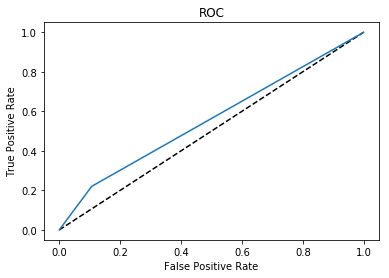

In [177]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_prepared, y_train)

Y_pred_prob = logisticRegr.predict(X_test_prepared)#[:,1]
score = logisticRegr.score(X_test_prepared, y_test)
print(score)
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [179]:
accuracy = accuracy_score(Y_pred_prob, y_test)
print(f'Model Accuracy: {accuracy:.2f}')
p_score = precision_score(y_test, Y_pred_prob)
print(f'\nPrecision: {p_score:.2f}')

r_score = recall_score(y_test, Y_pred_prob)
print(f'\nRecall: {r_score:.2f}')

f_score = f1_score(y_test, Y_pred_prob)
print(f'\nf1_score: {f_score:.2f}')

Model Accuracy: 0.69

Precision: 0.46

Recall: 0.22

f1_score: 0.30



The predictions are not good, as you can see. We have to work on the model, especially on the preprocessing. I am open to any suggestions for improvement.